## Part 0: Data Processing and EDA

## High level overview 


This project was interested in building various regression models to predict a restaurant's rating given it's features and a particular user's features. We first built a baseline model that took in global averages to make predictions, followed by regularized Ridge and Lasso regressions, a matrix factorizaiton approach, a KNN approach, and lastly an ensemble method that brought it all together. Overall it seems that fitted models performed marginally better than the baseline model, as you will see throughout the notebook code and explanations.


### Importing Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize


# Testing testing github 
from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  
# preprocessed review file with reviews only for restaurants 
with open('dataset/restaurant_reviews_trimmed.json') as f:
    review_data = [json.loads(line) for line in f]

# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

# convert array to list
restaurant_reviews = review_data[0] 

# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

## Part 1: Create a Baseline

Our first model was a simple baseline approach, written out as 

$$ \hat{Y}_{um} = \hat{\mu} + \hat{\theta}_{u} + \hat{\gamma}_m $$

where $\hat{\theta}_{u}$ and $\hat{\gamma}_m$ indicate the deviations of user $u$ and restaurant $m$ from some intercept paramter $\mu$. The baseline estimates we used in $\hat{\theta}_{u}$ and $\hat{\gamma}_m$ were the global averages, as seen and explained further below.

### Creating training, validating, and testing sets

In [3]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

As the dataset is so large, we had to take a subset of it to work with because of technical limitations of our computers.

In [4]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In the original dataset, "categories" is given as a list in each cell. We found all the unique categories here (e.g. French, Burgers, etc.).

In [5]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

Many of the categories were either inappropriate (e.g. laundry) or too rare to be useful. Here, we narrowed down the categories to the top 150.

In [6]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item
    
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [8]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

Here, we added user and business attributes to the reviews dictionary.

In [9]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

We decided to change "U_yelping_since", which was a year, to the number of years a user has been active (so that it would make more sense as a continuous variable).

In [11]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

This was just for convenience when performing regression later==we didn't want to use the drop function every time we referred to the dataframe.

In [12]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [13]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [14]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

There were many attributes with an unusually large number of NaNs (not 0 or False). We used mean imputation for many of these, but if more than half of the rows had missing values, we felt uncomfortable doing so and decided to drop the column entirely instead.

In [15]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

### Getting global averages

In [16]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

For this part of the project, we needed to include business and user ids for lookup purposes, which we had earlier deleted.

In [18]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)
print ("The global user average is {}".format(global_user_average))

# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)
print ("The global restaurant average is {}".format(global_restaurant_average))

# global review average
global_review_average = data_train['stars'].mean()
print ("The global review average is {}".format(global_review_average))

The global user average is 3.7280291378075754
The global restaurant average is 3.5649292823467786
The global review average is 3.708529901832855


The "global user average" takes a single user and his/her average rating given as one data point. The 'global restaurant average' does the same with individual restaurants. The 'global review average' averages every rating from every review. These are different values as each individual rating is weighted differently in each method.

### Getting restaurant and user biases

In [21]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [22]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

We decided to use the global user average and the global restaurant average for the user and restaurant bias calculation respectively (rather than global review average for everything) because we felt that it was most appropriate to compare a user's average rating to other users and a restaurant's average rating to other restaurants rather than to an average of all reviews.

### Baseline Model

In [23]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [24]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [25]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [26]:
print ("The accuracy score of the baseline model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, base_pred)))
print ("The accuracy score of the baseline model on the test set is {}"
       .format(metrics.accuracy_score(ytest, base_pred_test)))

The accuracy score of the baseline model on the train set is 0.3930700821070805
The accuracy score of the baseline model on the test set is 0.38866638770996476


In [27]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

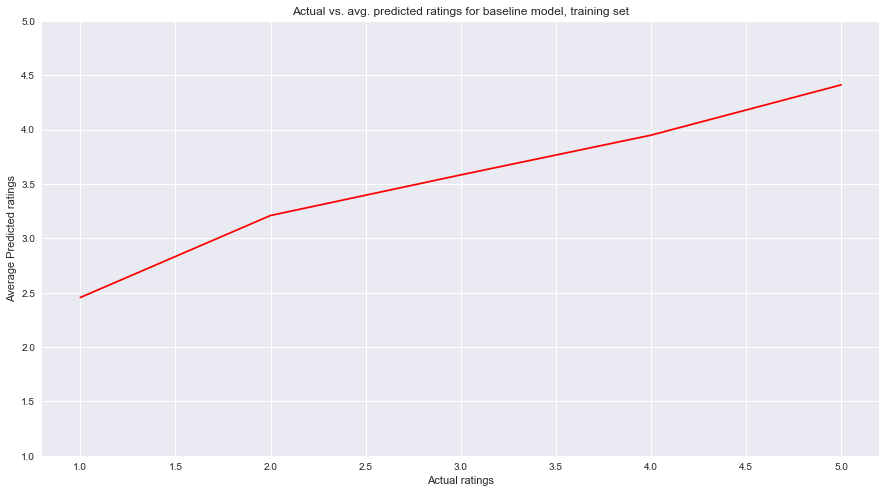

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, training set')
ax.set_ylim((1,5));

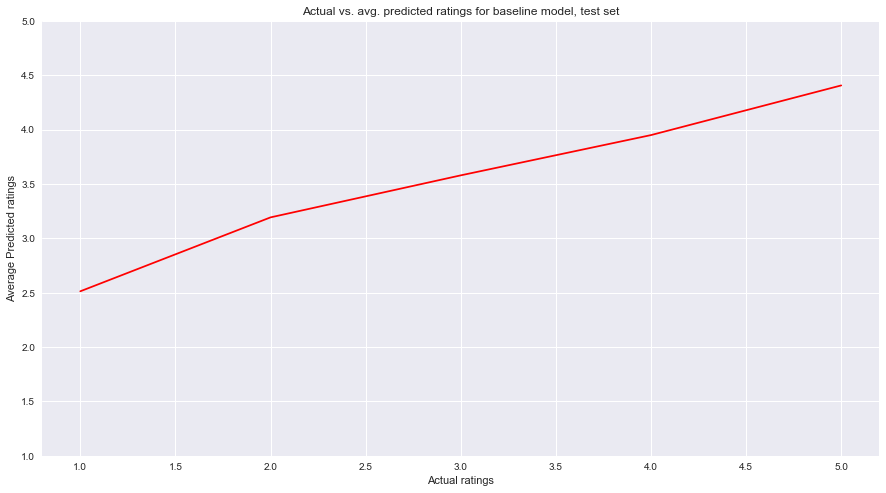

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, test set')
ax.set_ylim((1,5));

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.

## Part 2: Create a Regularized Regression

Now we are interested in building regularized regressions from our baseline model. In do so we are changing our regression fit from 

$$ \hat{Y}_{um} = \hat{\mu} + \hat{\theta}_{u} + \hat{\gamma}_m $$

to 

$$ \hat{Y}_{um} = \hat{\mu} + \bar{\theta}I_u + \hat{\gamma} I_m $$

where $I_u$ and $I_m$ are the indicator variables for the u-th user and the m-th restaurant in the feature matrix. We ended up building both Lasso and Ridge regressions to see if there were any improvements. 

### Linear Model

In [30]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We used a linear model rather than a logistic model as although the y-varaible was categorical (1, 2, 3, 4, or 5), it was ordinal.

In [31]:
ypred = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
predround = [int(round(x)) for x in ypred]
print ("The accuracy score of the linear model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, predround)))
predround_test = [int(round(x)) for x in ypred_test]
print ("The accuracy score of the linear model on the test set is {}"
       .format(metrics.accuracy_score(ytest, predround_test)))

The accuracy score of the linear model on the train set is 0.386104029068717
The accuracy score of the linear model on the test set is 0.38039731404546995


Here, we round the predictions from the model to the nearest integer to fit the predictions in the categories (1, 2, 3, 4, or 5).

### Lasso CV

In [32]:
model_lasso = LassoCV().fit(Xtrain, ytrain)

In [33]:
lasso_ypred = model_lasso.predict(Xtrain)
lasso_ypred_round = [int(round(x)) for x in lasso_ypred]
lasso_ypred_test = model_lasso.predict(Xtest)
lasso_ypred_test_round = [int(round(x)) for x in lasso_ypred_test]

In [34]:
print ("The accuracy score of the lasso model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, lasso_ypred_round)))
print ("The accuracy score of the lasso model on the test set is {}"
       .format(metrics.accuracy_score(ytest, lasso_ypred_test_round)))

The accuracy score of the lasso model on the train set is 0.3590227450665489
The accuracy score of the lasso model on the test set is 0.35427501145715024


### Ridge CV

In [35]:
model_ridge = RidgeCV().fit(Xtrain, ytrain)

In [36]:
ridge_ypred = model_ridge.predict(Xtrain)
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test = model_ridge.predict(Xtest)
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]

In [37]:

print ("The accuracy score of the ridge model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ridge_ypred_round)))
print ("The accuracy score of the ridge model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ridge_ypred_test_round)))

The accuracy score of the ridge model on the train set is 0.3858430530182884
The accuracy score of the ridge model on the test set is 0.3806563452686951


We will be using the regularized linear regression using the ridge method as it performed better than the lasso method for accuracy score (and very similarly to the naive linear regression).

In [38]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ridge_ypred_round})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ridge_ypred_test_round})

ridge_pred_avg = []
ridge_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    ridge_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    ridge_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

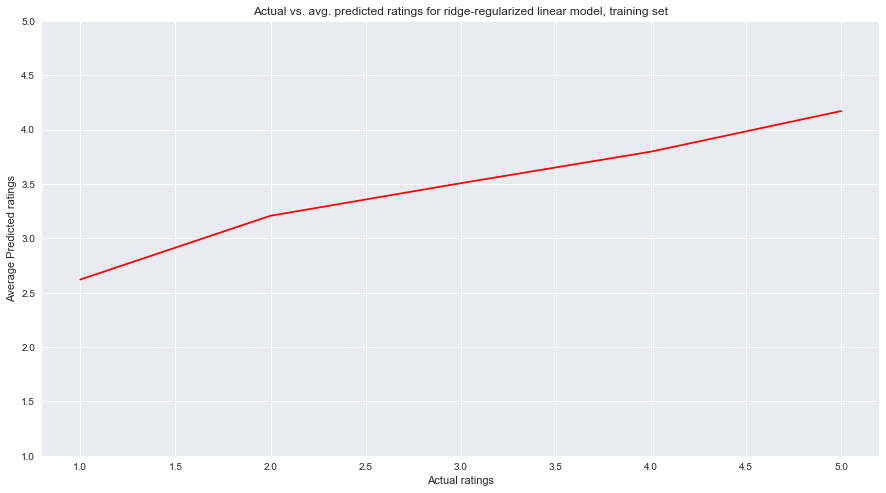

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, training set')
ax.set_ylim((1,5));

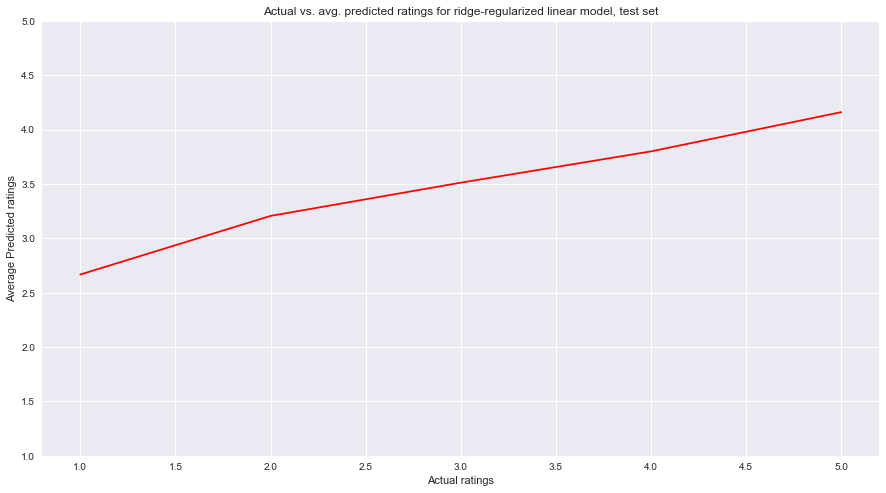

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, test set')
ax.set_ylim((1,5));

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings and underestimate for higher ratings.

## Part 3: Matrix Factorization

## Part 4: A Different Model

### Naive kNN Model

In [41]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

We used a KNeighborsRegressor model as we felt that a regressor was more appropriate than a classifier because although the y-variable was categorical (1, 2, 3, 4, 5), it was also ordinal.

In [42]:
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)

In [43]:
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.35406420010840545
The accuracy score of the knn model on the test set is 0.28160679060314425


### Cross-Validation

In [44]:
from sklearn.model_selection import KFold
means = []

for i in range(1, 11):
    knn = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    n_folds=5
    fold = 0
    
    valid_acc = [0, 0, 0, 0, 0]
    for train, valid in KFold(n_folds, shuffle=True).split(range(len(Xtrain))):
        train_set = data_train.iloc[train]
        valid_set = data_train.iloc[valid]
        
        X_cross_train = train_set.drop(['stars'], axis = 1)
        y_cross_train = train_set['stars']
        X_cross_valid = valid_set.drop(['stars'], axis = 1)
        y_cross_valid = valid_set['stars']

        knn.fit(X_cross_train, y_cross_train)
        
        y_hat_train_cross = np.round(knn.predict(X_cross_train)).astype(int)
        y_hat_valid_cross = np.round(knn.predict(X_cross_valid)).astype(int)
        
        valid_acc[fold] = metrics.accuracy_score(y_cross_valid, y_hat_valid_cross)
        fold += 1
    print(str(i) + ', ' + str(np.mean(valid_acc)))
    means.append(np.mean(valid_acc))
    
k = (means.index(np.max(means)) + 1)
print(str(k) + " = k model has highest mean validation accuracy score at: " + str(np.max(means)))

1, 0.323790977833
2, 0.293136195975
3, 0.290386036446
4, 0.287294571928
5, 0.282235538306
6, 0.278782754977
7, 0.275791357555
8, 0.274667399674
9, 0.273442673447
10, 0.272880503073
1 = k model has highest mean validation accuracy score at: 0.323790977833


Here, we had to hard-code cross-validation (rather than using cross_val_score because the default scoring method for kNeighborsRegressor was r2, and we wanted to use classification accuracy. The mean validation accuracy consistently decreases as k increases-- k=1 is the best-performing model.

### Final kNN Model

In [45]:
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
knn.fit(Xtrain, ytrain)
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 1.0
The accuracy score of the knn model on the test set is 0.3281128579114113


It is interesting that the highest performing model has k=1--this was true in both cross-validation and when looking at test accuracies separately (code not shown here for test accuracies of other models). This suggests that for a given user-restaurant combination, the single user-restaurant combination already in the dataset that is closest to the desired combination is most reflective of the desired combination (rather than an aggregate of several close combinations). Furthermore, this model has a relatively lower test accuracy than the baseline and the regression models, suggesting that it is not the best model to use for this dataset. Cross-validation did increase the accuracy score from the naive model (which used k = 5 as default).

In [46]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ypred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ypred_test})

knn_pred_avg = []
knn_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    knn_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    knn_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

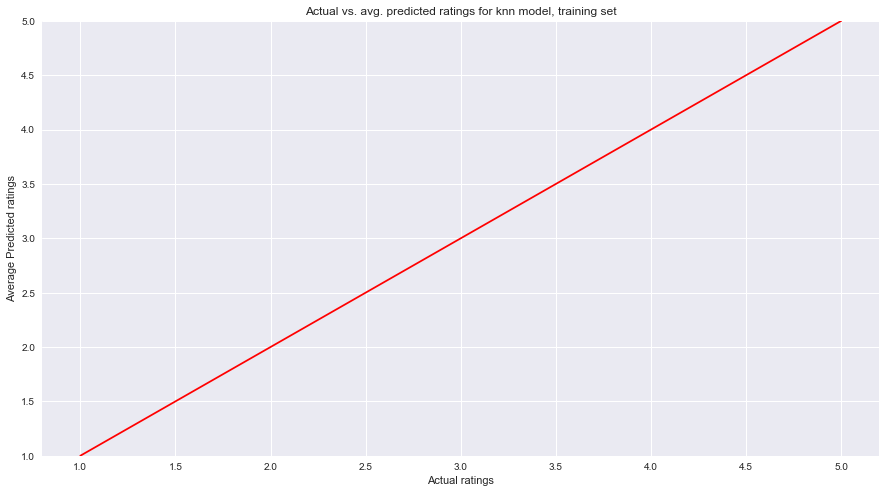

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5));

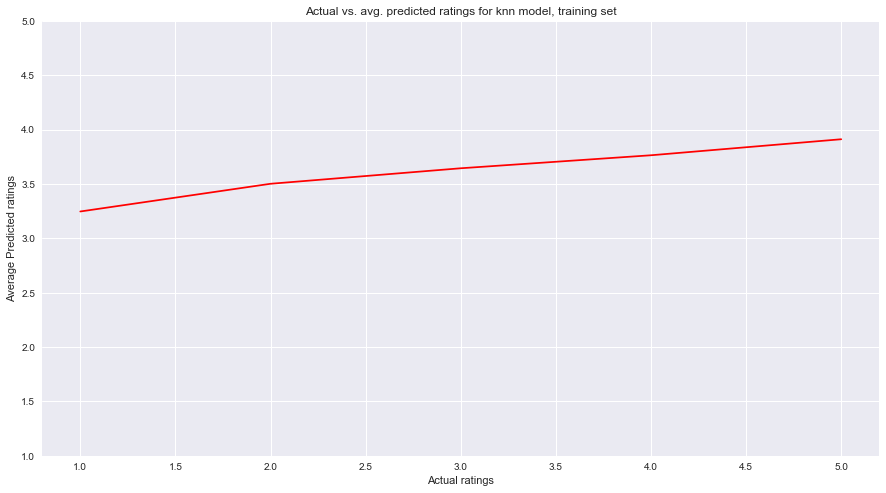

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5));

As k=1, the training set has a perfect match between actual ratings and predicted ratings. For the test set, however, the average predicted ratings start at around 3.25 when the actual ratings are 1 and increase slightly to about 3.75 when the actual ratings are 5 (much flatter graph than the other models).

## Part 5: Ensemble Method

### Majority Vote Model

In [49]:
from collections import Counter
predictions_train = []
predictions_test = []
counter_predictions_train = []
counter_predictions_test = []

# all the predictions in one place
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]
#matrix factorization train
#matrix factorization test
knn_pred_train = np.round(knn.predict(Xtrain)).astype(int)
knn_pred_test = np.round(knn.predict(Xtest)).astype(int)

for i in range(len(ytrain)):
    temp = []
    temp.append(base_pred[i])
    temp.append(ridge_ypred_round[i])
    #temp.append(matrix factorization train)
    temp.append(knn_pred_train[i])
    counter_predictions_train.append(Counter(temp))
    predictions_train.append(temp)
    
for i in range(len(ytest)):
    temp = []
    temp.append(base_pred_test[i])
    temp.append(ridge_ypred_test_round[i])
    #temp.append(matrix factorization test)
    temp.append(knn_pred_test[i])
    counter_predictions_test.append(Counter(temp))
    predictions_test.append(temp)

In [50]:
# majority votes
ensemble_pred_train = []
ensemble_pred_test = []

for i in range(len(counter_predictions_train)):
    value, count = counter_predictions_train[i].most_common()[0]
    ensemble_pred_train.append(value)
    
for i in range(len(counter_predictions_test)):
    value, count = counter_predictions_test[i].most_common()[0]
    ensemble_pred_test.append(value)

In [51]:
print ("The accuracy score of the ensemble model (majority vote) on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ensemble_pred_train)))
print ("The accuracy score of the ensemble model (majority vote) on the test set is {}"
       .format(metrics.accuracy_score(ytest, ensemble_pred_test)))

The accuracy score of the ensemble model (majority vote) on the train set is 0.4755585891233212
The accuracy score of the ensemble model (majority vote) on the test set is 0.3995058481280013


This ensemble method predicts by taking a majority vote of every model's prediction for a given predictor set. This improves upon all the models--both training and test accuracies are higher than any individual component model of the ensemble model (excluding training accuracy for kNN, which was 1 because k = 1).}

In [52]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ensemble_pred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ensemble_pred_test})

majority_pred_avg = []
majority_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    majority_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    majority_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

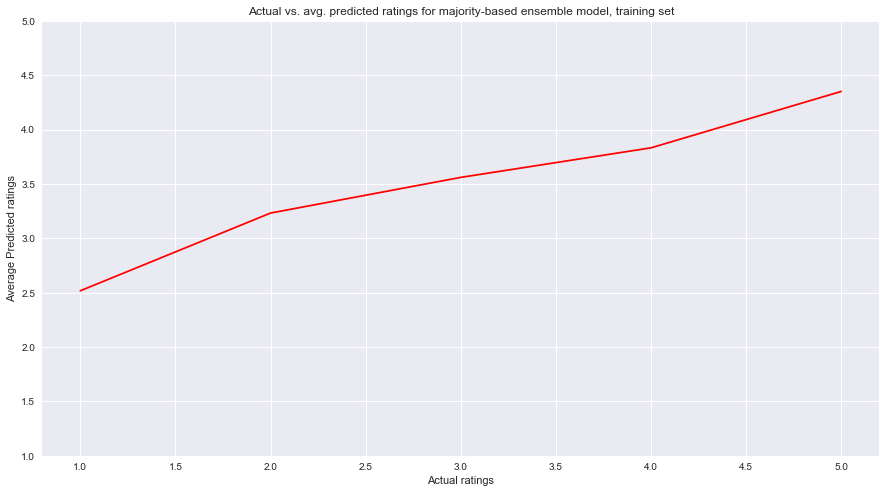

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5));

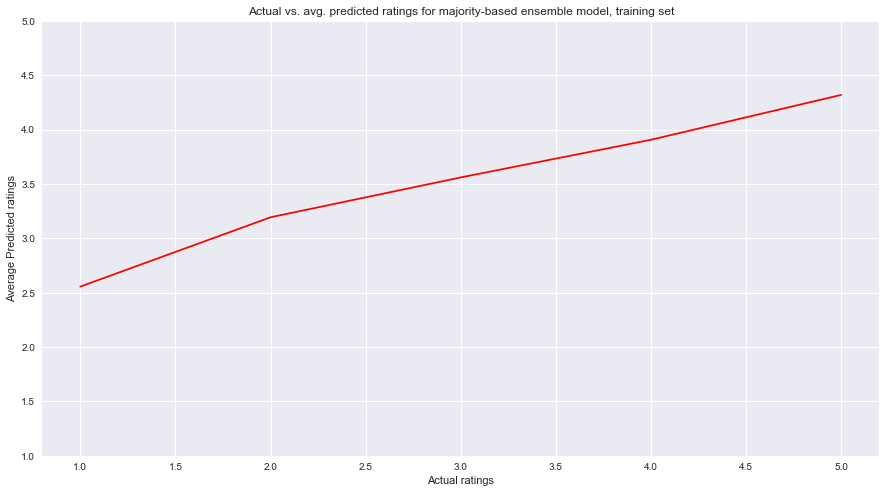

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5));

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.

### Ensemble Method Using Logistic Regression

In [55]:
# logistic regression metaclassifier
logreg = LogisticRegressionCV()
y_hat_test = logreg.fit(predictions_train, ytrain).predict(predictions_test)
y_hat_train = logreg.fit(predictions_train, ytrain).predict(predictions_train)

print("Train LogReg: ", metrics.accuracy_score(ytrain, y_hat_train))
print("Test LogReg: ", metrics.accuracy_score(ytest, y_hat_test))

Train LogReg:  0.763495473069
Test LogReg:  0.359615039751


This model performed significantly better on the training set; however, it actually performed *worse* on the test set. This may be because of the kNN model being weighted more because of its high training accuracy due to its parameter k being 1.

In [56]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : y_hat_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : y_hat_test})

log_pred_avg = []
log_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    log_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    log_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

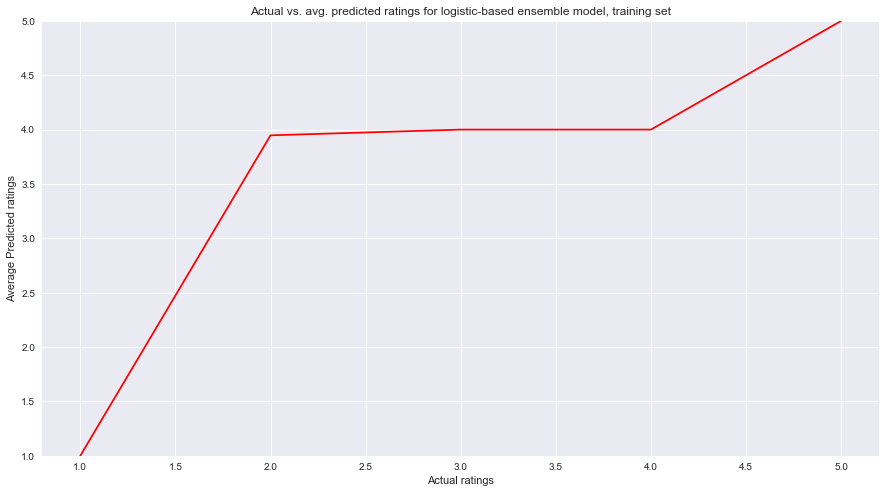

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5));

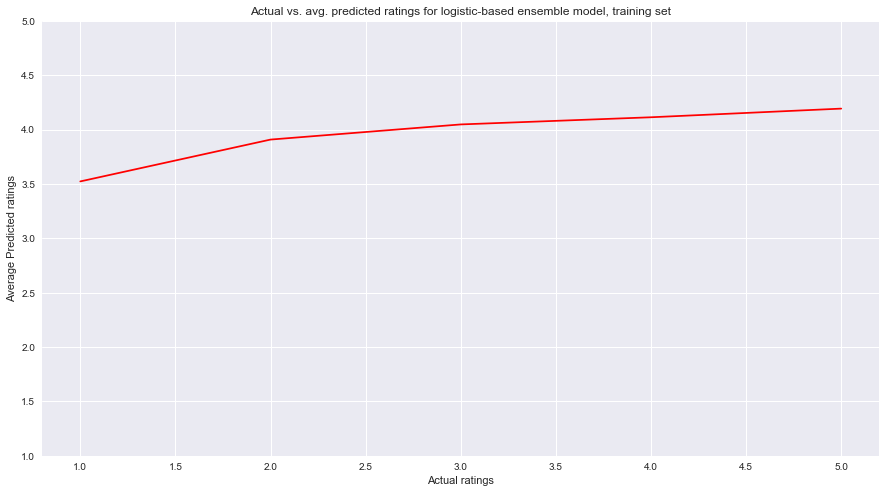

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5));

For the training set, the model performed well for when actual ratings were 1, 4, and 5 (not 2 and 3). The line was very flat for the test set, reflecting the large influence that the knn model had using this ensemble method.